In [1]:
import pathlib
import numpy as np
import skimage
import plotly.graph_objects as go

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib.path import Path as pltpath
from matplotlib.gridspec import GridSpec

In [80]:
import open3d as o3d
from copy import deepcopy

In [36]:
def classify_by_polygon(xy, polygon):

    polygon_path = pltpath(polygon)
    inside_polygon = polygon_path.contains_points(xy)

    return inside_polygon


def pin_detection_by_hsv_colospace(
    color_array, colorspace_roi=None, hue_origin=0, show_3d=False
):

    hsv_color = skimage.color.rgb2hsv(color_array)

    color_type = ''
    if len(color_array.shape) == 3:  # (h, w, 3) image array
        hsv_reshaped = hsv_color.reshape(-1, 3)
        color_type = 'image'

    elif len(color_array.shape) == 2 and color_array.shape[1] == 3: # (x, 3) point cloud color array
        hsv_reshaped = hsv_color
        color_type = 'pcd'
    
    else:
        print('Not a standard image color (h,w,3) or pcd color (n, 3)')
        return None

    # remove duplicates
    ar, idx = np.unique(hsv_reshaped, axis=0, return_index=True)

    # 获取 H、S、V 通道
    h = (hsv_reshaped[:, 0] - hue_origin) % 1 + hue_origin  # support offset of hue
    s = hsv_reshaped[:, 1]
    v = hsv_reshaped[:, 2]

    h_flatten = h.flatten()
    s_flatten = s.flatten()
    v_flatten = v.flatten()

    h_flatten_unique = h_flatten[idx]
    s_flatten_unique = s_flatten[idx]
    v_flatten_unique = v_flatten[idx]

    # thershold by roi polygon
    hs = classify_by_polygon(np.row_stack([h_flatten, s_flatten]).T, colorspace_roi['H-S'])
    hv = classify_by_polygon(np.row_stack([h_flatten, v_flatten]).T, colorspace_roi['H-V'])
    sv = classify_by_polygon(np.row_stack([s_flatten, v_flatten]).T, colorspace_roi['S-V'])

    mask = hs * hv * sv

    if color_type == 'image':
        mask = mask.reshape(hsv_image.shape[0:2])

    if show_3d:

        if color_array.max() > 1:
            divider = 255
        else:
            divider = 1

        if color_type == 'image':
            c_flatten = color_array.reshape(-1, 3) / divider
        else:
            c_flatten = color_array / divider

        c_flatten_unique = c_flatten[idx]

        # 创建散点图
        fig = go.Figure(data=[go.Scatter3d(x=h_flatten_unique, y=s_flatten_unique, z=v_flatten_unique, mode='markers',
                                        marker=dict(size=2, color=c_flatten_unique, opacity=0.8))])

        # 设置图表布局
        fig.update_layout(scene=dict(
                            xaxis_title='Hue(X)', 
                            yaxis_title='Saturation(Y)', 
                            zaxis_title='Value(Z)'),
                          margin=dict(l=0, r=0, b=0, t=0))

        fig.show()

    return mask

In [3]:
colorspace_roi = {
    'S-V': [  # Y-Z
        [0.3, 1],
        [0.38, 0.99],
        [0.6 , 0.95],
        [0.77, 0.8],
        [0.87, 0.65],
        [1,    0.4],
        [1,    0.17],
        [0.9,  0.0], 
        [0.7,  0.0],
        [0.3,  0.05],
        [0.16, 0.12],
        [0.03, 0.2],
        [0.01, 0.5],
        [0.0, 0.66],
        [0.0,  1],
    ],
    'H-S': [ # X-Y
        [0.1,  1], 
        [0.03, 0.86],
        [-0.05, 0.67],
        [-0.06,  0.5], 
        [-0.05,  0.32],
        [0,    0.06],
        [0.1, 0.00],
        [0.4, 0.00],
        [0.6,  0.05],
        [0.2, 0.25],
        [0.13, 0.6],
        [0.12, 0.74],
    ],
    'H-V': [  # X-Z
        [0.12, 1],
        [0.16, 0.85],
        [0.2, 0.8],
        [0.8, 0.6],
        [0.8, 0.4],
        [0.16, 0.05],
        [0.12, 0.0],
        [0.08, 0.0],
        [0.0,  0.0],
        [-0.03,  0.2],
        [-0.05,  0.4],
        [-0.02,  0.61],
        [0.03, 0.73],
        [0.05, 0.8],
        [0.08, 0.88]
    ]
}

In [12]:
sfm_pcd_folder = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin/2_SfM/2_pcd')

In [5]:
potato_id = '2R1-1'

In [14]:
# get the sfm pcd
sfm_pcd_path = sfm_pcd_folder / f"{potato_id}_30000.ply"
sfm_pcd = o3d.io.read_point_cloud( str(sfm_pcd_path) )

In [37]:
o3d.visualization.draw_geometries([sfm_pcd])

In [38]:
colors = np.asarray(sfm_pcd.colors)

In [39]:
pin_idx = pin_detection_by_hsv_colospace(colors, colorspace_roi, hue_origin=-0.2, show_3d=True)

In [40]:
pin_idx

array([ True,  True,  True, ...,  True,  True,  True])

In [49]:
pin_pcd = sfm_pcd.select_by_index(np.where(~pin_idx)[0])
pin_pcd.paint_uniform_color([1, 0, 0])
pin_pcd

PointCloud with 91 points.

In [53]:
pin_pcd.points

std::vector<Eigen::Vector3d> with 91 elements.
Use numpy.asarray() to access data.

In [50]:
o3d.visualization.draw_geometries([sfm_pcd, pin_pcd])

In [58]:
keeped, keeped_idx = pin_pcd.remove_statistical_outlier(nb_neighbors=50, std_ratio=2.0)

In [59]:
keeped_idx

[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

In [62]:
removed_pcd = pin_pcd.select_by_index(keeped_idx, invert=True)
removed_pcd.paint_uniform_color([0,1,1])

PointCloud with 5 points.

In [63]:
o3d.visualization.draw_geometries([sfm_pcd, pin_pcd, removed_pcd])

# Summary

In [1]:
import pathlib
import numpy as np
import skimage
import plotly.graph_objects as go

from scipy.spatial import ConvexHull

import open3d as o3d

import matplotlib.pyplot as plt
from matplotlib.path import Path as pltpath
from matplotlib.gridspec import GridSpec

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [71]:
def classify_by_polygon(xy, polygon):

    polygon_path = pltpath(polygon)
    inside_polygon = polygon_path.contains_points(xy)

    return inside_polygon


def pin_detection_by_hsv_colospace(
    color_array, colorspace_roi=None, hue_origin=0, show_3d=False
):

    hsv_color = skimage.color.rgb2hsv(color_array)

    color_type = ''
    if len(color_array.shape) == 3:  # (h, w, 3) image array
        hsv_reshaped = hsv_color.reshape(-1, 3)
        color_type = 'image'

    elif len(color_array.shape) == 2 and color_array.shape[1] == 3: # (x, 3) point cloud color array
        hsv_reshaped = hsv_color
        color_type = 'pcd'
    
    else:
        print('Not a standard image color (h,w,3) or pcd color (n, 3)')
        return None

    # remove duplicates
    ar, idx = np.unique(hsv_reshaped, axis=0, return_index=True)

    # 获取 H、S、V 通道
    h = (hsv_reshaped[:, 0] - hue_origin) % 1 + hue_origin  # support offset of hue
    s = hsv_reshaped[:, 1]
    v = hsv_reshaped[:, 2]

    h_flatten = h.flatten()
    s_flatten = s.flatten()
    v_flatten = v.flatten()

    h_flatten_unique = h_flatten[idx]
    s_flatten_unique = s_flatten[idx]
    v_flatten_unique = v_flatten[idx]

    # thershold by roi polygon
    hs = classify_by_polygon(np.row_stack([h_flatten, s_flatten]).T, colorspace_roi['H-S'])
    hv = classify_by_polygon(np.row_stack([h_flatten, v_flatten]).T, colorspace_roi['H-V'])
    sv = classify_by_polygon(np.row_stack([s_flatten, v_flatten]).T, colorspace_roi['S-V'])

    mask = hs * hv * sv  # potato index
    mask = ~mask  # pin index

    if color_type == 'image':
        mask = mask.reshape(hsv_image.shape[0:2])

    if show_3d:

        if color_array.max() > 1:
            divider = 255
        else:
            divider = 1

        if color_type == 'image':
            c_flatten = color_array.reshape(-1, 3) / divider
        else:
            c_flatten = color_array / divider

        c_flatten_unique = c_flatten[idx]

        # 创建散点图
        fig = go.Figure(data=[go.Scatter3d(x=h_flatten_unique, y=s_flatten_unique, z=v_flatten_unique, mode='markers',
                                        marker=dict(size=2, color=c_flatten_unique, opacity=0.8))])

        # 设置图表布局
        fig.update_layout(scene=dict(
                            xaxis_title='Hue(X)', 
                            yaxis_title='Saturation(Y)', 
                            zaxis_title='Value(Z)'),
                          margin=dict(l=0, r=0, b=0, t=0))

        fig.show()

    return mask

In [52]:
colorspace_roi = {
    'S-V': [  # Y-Z
        [0.3, 1],
        [0.38, 0.99],
        [0.6 , 0.95],
        [0.77, 0.8],
        [0.87, 0.65],
        [1,    0.4],
        [1,    0.17],
        [0.9,  0.0], 
        [0.7,  0.0],
        [0.3,  0.05],
        [0.16, 0.12],
        [0.03, 0.2],
        [0.01, 0.5],
        [0.0, 0.66],
        [0.0,  1],
    ],
    'H-S': [ # X-Y
        [0.1,  1], 
        [0.03, 0.86],
        [-0.05, 0.67],
        [-0.06,  0.5], 
        [-0.05,  0.32],
        [0,    0.06],
        [0.1, 0.00],
        [0.4, 0.00],
        [0.6,  0.05],
        [0.2, 0.25],
        [0.13, 0.6],
        [0.12, 0.74],
    ],
    'H-V': [  # X-Z
        [0.12, 1],
        [0.16, 0.85],
        [0.2, 0.8],
        [0.3, 0.6],
        [0.3, 0.4],
        [0.16, 0.05],
        [0.12, 0.0],
        [0.08, 0.0],
        [0.0,  0.0],
        [-0.03,  0.2],
        [-0.05,  0.4],
        [-0.02,  0.61],
        [0.03, 0.73],
        [0.05, 0.8],
        [0.08, 0.88]
    ]
}

In [4]:
sfm_pcd_folder = pathlib.Path(r'/home/crest/w/hwang_Pro/datasets/3DPotatoTwin/2_SfM/2_pcd')

potato_id = '2R1-1'

In [74]:
def extract_pin_from_sfm_pcd(sfm_pcd_folder, potato_id, visualize=False):
    # get the sfm pcd
    sfm_pcd_path = sfm_pcd_folder / f"{potato_id}_30000.ply"
    sfm_pcd = o3d.io.read_point_cloud( str(sfm_pcd_path) )

    colors = np.asarray(sfm_pcd.colors)

    pin_mask = pin_detection_by_hsv_colospace(colors, colorspace_roi, hue_origin=-0.2, show_3d=False)
    pin_idx = np.where(pin_mask)[0]

    pin_pcd = sfm_pcd.select_by_index(pin_idx)
    pin_pcd.paint_uniform_color([1, 0, 0])

    keeped, keeped_idx = pin_pcd.remove_radius_outlier(nb_points=15, radius=0.01)

    if visualize:
        removed_pcd = pin_pcd.select_by_index(keeped_idx, invert=True)
        removed_pcd.paint_uniform_color([0,1,1])

        o3d.visualization.draw_geometries(
            [sfm_pcd, keeped, removed_pcd],
            window_name = f"{potato_id}'s Pin"
        )

    # return keeped
    return pin_idx[keeped_idx], sfm_pcd

In [56]:
pin_keeped_pcd, pin_keeped_idx = extract_pin_from_sfm_pcd(sfm_pcd_folder, '2R1-1', visualize=True)

In [57]:
pin_keeped_pcd, pin_keeped_idx = extract_pin_from_sfm_pcd(sfm_pcd_folder, '2R1-9', visualize=True)

In [58]:
# the problem one
pin_keeped_pcd, pin_keeped_idx = extract_pin_from_sfm_pcd(sfm_pcd_folder, 'R3-9', visualize=True)

In [61]:
# the problem one
pin_keeped_pcd, pin_keeped_idx = extract_pin_from_sfm_pcd(sfm_pcd_folder, 'R4-4', visualize=True)

TypeError: cannot unpack non-iterable open3d.cuda.pybind.geometry.PointCloud object

Remove outliers by color clustering + dbscan

In [121]:
# the problem one
pin_idx, sfm_pcd = extract_pin_from_sfm_pcd(sfm_pcd_folder, 'R4-3')

In [122]:
o3d.visualization.draw_geometries([sfm_pcd.select_by_index(pin_idx)])

In [77]:
pin_pcd = sfm_pcd.select_by_index(pin_idx)

In [97]:
dbscan_labels = np.asarray(pin_pcd.cluster_dbscan(eps=0.002, min_points=10))
dbscan_labels

array([ 0,  1,  0,  0,  2,  0,  0,  3,  0,  1,  3,  0,  1,  3,  1,  3,  2,
        3,  0,  0,  0,  0,  0,  2,  3,  2,  1,  1,  0,  3,  0,  3,  0,  3,
        3,  3,  2,  3,  0,  0,  0,  0,  1,  0,  0,  3,  0,  3,  0,  0,  0,
        0,  3,  0,  3,  1,  2,  0,  0,  1,  0,  0,  2,  0,  0,  0,  0,  2,
        2,  1,  3,  0,  3,  0,  2,  1,  3,  1,  2,  1,  1,  0,  0,  0,  0,
        0,  0,  0,  3,  3,  0,  3,  1,  0,  1,  0,  2,  1,  3,  0,  0,  0,
        0,  0,  0,  2,  0,  1,  3,  0,  3,  1,  0,  2,  3,  2,  0,  0,  3,
        2,  3,  3,  0,  0,  2,  0,  0,  0,  2,  1,  0,  0,  2,  3,  2,  3,
        0,  0,  3,  3,  3,  2,  0,  2,  0,  2,  0,  0,  3,  0,  3,  0,  2,
        2,  2,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  3,  3,  1,  0,  0,
        0,  3,  3,  1,  3,  3,  1,  3,  0,  0,  0,  1,  3,  2,  0,  0,  1,
        1,  1,  1,  3,  2,  0,  0,  2,  0,  0,  2,  1,  0,  2,  3,  1,  3,
        3,  3,  0,  3,  1,  0,  3,  2,  2,  0,  1,  1,  1,  0,  0,  1,  3,
        0,  3,  2,  0,  3

In [93]:
pin_pcd_dblabels = deepcopy(pin_pcd)

In [94]:
max_label = dbscan_labels.max()
colors = plt.get_cmap("tab20")(dbscan_labels / (max_label if max_label > 0 else 1))
colors[dbscan_labels < 0] = 0
pin_pcd_dblabels.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [95]:
o3d.visualization.draw_geometries([pin_pcd_dblabels])

Calculate the average color of each class

In [101]:
rgb_color = np.asarray(pin_pcd.colors)

for lb in np.unique(dbscan_labels):
    if lb >= 0:
        cls_idx = np.where(dbscan_labels == lb)[0]

        rgb = rgb_color[cls_idx, :]

        hsv = skimage.color.rgb2hsv(rgb)

        median_hsv = np.median(hsv, axis=0)

        print(lb, median_hsv)



0 [0.15981735 0.63137255 0.99215686]
1 [0.14619883 0.57283993 0.78823529]
2 [0.12785388 0.30120482 0.98039216]
3 [0.12869198 0.32258065 0.98039216]


### reference color loader

In [114]:
ref_color_folder = pathlib.Path('./pin_ref/')

ref_color_rgb = []
ref_color_hsv = {}

for i in range(1,11):

    ref_img_path = ref_color_folder / f"{i}.png"

    ref_color_imarray = plt.imread( str(ref_img_path) )

    mask = ref_color_imarray[:,:,3] == 1

    ref_color_masked = ref_color_imarray[mask]

    ref_color_rgb.append(np.median(ref_color_masked[:,0:3], axis=0))
    ref_color_hsv[i] = np.median(skimage.color.rgb2hsv(ref_color_masked[:,0:3]), axis=0)

visualize median color

In [113]:
from matplotlib.colors import ListedColormap

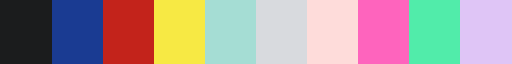

In [116]:
custom_colormap = ListedColormap(np.asarray(ref_color_rgb))
custom_colormap

Calcuate the distance of each cluster to standard references

In [118]:
rgb_color = np.asarray(pin_pcd.colors)

for lb in np.unique(dbscan_labels):
    if lb >= 0:
        cls_idx = np.where(dbscan_labels == lb)[0]

        rgb = rgb_color[cls_idx, :]

        hsv = skimage.color.rgb2hsv(rgb)

        median_hsv = np.median(hsv, axis=0)

        # print(lb, median_hsv)

        # calculate the color istance
        ## !! change here !!!!!
        ref_hsv = ref_color_hsv[4]

        hsv_distance = abs(median_hsv - ref_hsv)

        print(lb, median_hsv, hsv_distance.sum())

0 [0.15981735 0.63137255 0.99215686] 0.12500283653109176
1 [0.14619883 0.57283993 0.78823529] 0.33993760663330524
2 [0.12785388 0.30120482 0.98039216] 0.4612902095610346
3 [0.12869198 0.32258065 0.98039216] 0.4390762818330286


check if 0 is the collect class

In [120]:
picked = pin_pcd_dblabels.select_by_index(np.where(dbscan_labels == 0)[0])

o3d.visualization.draw_geometries([picked])

What if just using the HSV reference to clustering color directly?